# 3 Data Preprocessing<a id='3_Data_Preprocessing'></a>

## 3.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
    * [2.2.1 Recap Of Data Science Problem](#2.2.1_Recap_Of_Data_Science_Problem)
    * [2.2.2 Objective of Data Wrangling](#2.2.2_Objective_of_Data_Wrangling)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Load The Data](#2.4_Load_The_Data)
  * [2.5 Explore The Data](#2.5_Explore_The_Data)
    * [2.5.1 Find Duplicates](#2.5.1_Find_Duplicates)
    * [2.5.2 Find Missing Values](#2.5.2_Find_Missing_Values)
    * [2.5.3 Find Dimensions for Time Series](#2.5.3_Find_Dimensions_for_Time_Series)
      * [2.5.3.1 Total Number of Time Series](#2.5.3.1_Total_Number_of_Time_Series)
      * [2.5.3.2 Time Span of Time Series](#2.5.3.2_Time_Span_of_Time_Series)
        * [2.5.3.2.1 Time Span of Time Series in Weekly_sales Dataframe](#2.5.3.2.1_Time_Span_of_Time_Series_in_Weekly_sales_Dataframe)
        * [2.5.3.2.2 Time Span of Time Series in Features Dataframe](#2.5.3.2.2_Time_Span_of_Time_Series_in_Features _Dataframe)
    * [2.5.4 Time Trend of Weekly Sales](#2.5.4_Time_Trend_of_Weekly_Sales)
      * [2.5.4.1 Time Trend of Weekly Sales for Dept](#2.5.4.1_Time_Trend_of_Weekly_Sales_for_Dept)
      * [2.5.4.2 Completeness of Weekly Sales Records](#2.5.4.2_Completeness_of_Weekly_Sales_Records)
    * [2.5.5 Categorical Features](#2.5.5_Categorical_Features)
      * [2.5.5.1 Store Type](#2.5.5.1_Store_Type)
        * [2.5.5.1.1 Store Size for Different Store Type](#2.5.5.1.1_Store_Size_for_Different_Store_Type)
        * [2.5.5.1.2 Weekly Sales for Different Store Type](#2.5.5.1.2_Weekly_Sales_for_Different_Store_Type)
      * [2.5.5.2 Holiday Effect](#2.5.5.2_Holiday_Effect)
    * [2.5.6 Numerical Features](#2.5.6_Numerical_Features)
      * [2.5.6.1 Numerical Variables in features df](#2.5.6.1_Numerical_Variables_in_Features_df)
        * [2.5.6.1.1 Numerical Variables Summary](#2.5.6.1.1_Numerical_Variables_Summary)
        * [2.5.6.1.2 Numerical Variables Distribution](#2.5.6.1.2_Numerical_Variables_Distribution)
      * [2.5.6.2 Numerical Variables in weekly_sales_type df](#2.5.6.2_Numerical_Variables_in_Weekly_Sales_Type_df)
  * [2.6 Merge The Data](#2.6_Merge_The_Data)
  * [2.7 Save The dData](#2.7_Save_The_data)
  * [2.8 Summary](#2.8_Summary)


## 3.2 Objectives<a id='3.2_Objectives'></a>

2. Image preprocessing 
    
    1) Image normalization due to various image intensity 
    
    2) noise reduction technique - guassian blurring
    
    3) image augmentation
    
    4) ROI selection?
    

3. feature extraction
    1) statistical features like intensity mean, standard deviation, skewness, and kurtosis from the pixel intensity distributions.
 
    2) Shape and Contour Features: Hough Transform for detecting shapes in the X-ray which might be indicative of particular conditions.
    
    3) texture/orientation features: Gabor Filters
    
    4) deep learning CNNs
  
4. sample imbalance
   1) number in different cases are largely different, data imbalance might be a concern
    

In [1]:
pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 660.6 kB/s eta 0:00:01
   ---------------------------- ----------- 92.2/129.1 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 3.3 Imports<a id='3.3_Imports'></a>

In [2]:
#import libs  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Flatten,BatchNormalization, Conv2D,MaxPool2D,Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner

from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score
import itertools
import os
import shutil
import random
import glob


import seaborn as sns
import os

import cv2
from sklearn.model_selection import train_test_split



## 3.4 Test_Train_split<a id='3.4_Test_Train_split'></a>

In [3]:
categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']  # List of categories

'''
def select_files(folder,proportion):
    files=[f for f in os.listdir(folder) if f.lower().endswith('.png','.jpg','jpeg')]
    num_selected_files=int(len(files)*proportion)
    selected_files=np.random.cjoice()files,num_selected_files,replace=False)
    return selected_files
'''

# Set a random seed for reproducibility
seed = 42

# Define a split ratio
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2 

# Define the base directories for train and test sets
base_train_dir = 'train'
base_validation_dir = 'validation'
base_test_dir = 'test'

# Create train and test directories if they don't exist
if not os.path.exists(base_train_dir):
    os.makedirs(base_train_dir)
    
if not os.path.exists(base_validation_dir):
    os.makedirs(base_validation_dir)

if not os.path.exists(base_test_dir):
    os.makedirs(base_test_dir)

for category in categories:
    # Create category subdirectories in train and test directories
    train_category_dir = os.path.join(base_train_dir, category)
    validation_category_dir = os.path.join(base_validation_dir, category)
    test_category_dir = os.path.join(base_test_dir, category)

    if not os.path.exists(train_category_dir):
        os.makedirs(train_category_dir)
        
    if not os.path.exists(validation_category_dir):
        os.makedirs(validation_category_dir)
    
    if not os.path.exists(test_category_dir):
        os.makedirs(test_category_dir)

    # Get the list of images from the first subdirectory of the category
    subfolders = [d for d in os.listdir(category) if os.path.isdir(os.path.join(category, d))]  
    first_subfolder = os.path.join(category, subfolders[0])
    if os.path.isdir(first_subfolder):
        images = [img for img in os.listdir(first_subfolder) if img.endswith('.png')]

    # Train-test split for the current category
     # Select only 10% of images to use for this category
    _, use_images = train_test_split(images, test_size=0.2, random_state=seed)
    train_val_images, test_images = train_test_split(use_images, test_size=test_ratio, random_state=seed)
    train_images, val_images = train_test_split(train_val_images, test_size=validation_ratio/(train_ratio+validation_ratio), random_state=seed)

    # Move images to their respective train/test category directories
    for img in train_images:
        source = os.path.join(category, subfolders[0], img)
        destination = os.path.join(train_category_dir, img)
        shutil.copy(source, destination)
        
    for img in val_images:
        source = os.path.join(category, subfolders[0], img)
        destination = os.path.join(validation_category_dir, img)
        shutil.copy(source, destination)

    for img in test_images:
        source = os.path.join(category, subfolders[0], img)
        destination = os.path.join(test_category_dir, img)
        shutil.copy(source, destination)



## 3.5 Baseline Model

### 3.5.1 Image preprocessing

In [4]:
#generate batches of data which can be put in sequential model 

#you can add augmentation or rescaling parameters here
#Frist, start without setting any parameters, since basic model already add rescaling function
Image_generator=ImageDataGenerator(rescale=1./255)

#creat batches of data from directory where train,val,test dataset are, target_size are set as 224 since pre-trained model VGG16 is using image with size of 224
train_batches=Image_generator.flow_from_directory(directory=base_train_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
val_batches=Image_generator.flow_from_directory(directory=base_validation_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
#only set shuffle to be false for test dataset since we need to use test dataset as reference for confusion matrix where
test_batches=Image_generator.flow_from_directory(directory=base_test_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32,shuffle=False)


Found 2955 images belonging to 4 classes.
Found 425 images belonging to 4 classes.
Found 847 images belonging to 4 classes.


In [5]:
#each batch contains 10 images and corresponding labels
imgs,labels=next(train_batches)

def adjustImages(image):
    min_val=np.min(img)
    max_val=np.max(img)
    adjusted_img=(img-min_val)/(max_val-min_val)
    return adjusted_img

In [6]:
num_images=imgs.shape[0]

In [7]:
num_images

32

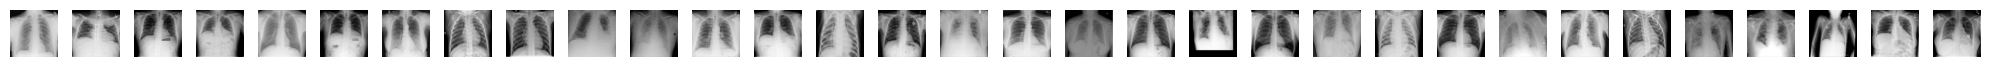

In [8]:
fig,axes=plt.subplots(1,num_images,figsize=(20,10))

    
for i,ax in enumerate(axes):
        
    ax.imshow(imgs[i])
    ax.axis('off')
    plt.tight_layout()
#    ax.set_title(f"label:{np.argmax(label[i])}")
plt.tight_layout()
plt.show()

### 3.5.2 Basic CNN model

In [9]:
#build baseline model with minimal preprocessing by applying only normalization to the images
##input_shape=() must be in the first layer of the model, if the first layer is rescale=1./255, then add input_shape in this layer instead of conv2D
basic_CNN_model=Sequential([
                      Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(299,299,3)),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Conv2D(filters=32, kernel_size=(3,3),activation='relu'),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Flatten(),
                      Dense(units=4,activation='softmax')
                    ])
        #rescaling layer  to normaliza the input images, use 1./255 not becasue of image dimension, but because it's related to pixel intensity range, 
        #pixel intensity is represented by 8-bit value, range from 0-255, not the height by width of the image
        #padding is used to maintain the edge information, keep size of feature map same as input images
        #each filter is to detect specific type of feature, each filter will produce feature map
                      

In [10]:
basic_CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 170528)            0         
                                                                 
 dense (Dense)               (None, 4)                 6

In [11]:
basic_CNN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
basic_CNN_model.fit(x=train_batches,validation_data=val_batches,epochs=10,verbose=1)

Epoch 1/10
93/93 [==============================] - 41s 432ms/step - loss: 0.9841 - accuracy: 0.5926 - val_loss: 1.0224 - val_accuracy: 0.5435
Epoch 2/10
93/93 [==============================] - 41s 445ms/step - loss: 0.8094 - accuracy: 0.6599 - val_loss: 0.7062 - val_accuracy: 0.7271
Epoch 3/10
93/93 [==============================] - 42s 447ms/step - loss: 0.6782 - accuracy: 0.7262 - val_loss: 0.6823 - val_accuracy: 0.7388
Epoch 4/10
93/93 [==============================] - 42s 452ms/step - loss: 0.6181 - accuracy: 0.7553 - val_loss: 0.6227 - val_accuracy: 0.7647
Epoch 5/10
93/93 [==============================] - 43s 459ms/step - loss: 0.5511 - accuracy: 0.7915 - val_loss: 0.6029 - val_accuracy: 0.7553
Epoch 6/10
93/93 [==============================] - 44s 477ms/step - loss: 0.5093 - accuracy: 0.8061 - val_loss: 0.6665 - val_accuracy: 0.7224
Epoch 7/10
93/93 [==============================] - 44s 477ms/step - loss: 0.4794 - accuracy: 0.8146 - val_loss: 0.5917 - val_accuracy: 0.7859

### 3.5.3 Predict the Image 

In [15]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
test_imgs,test_labels=next(test_batches)

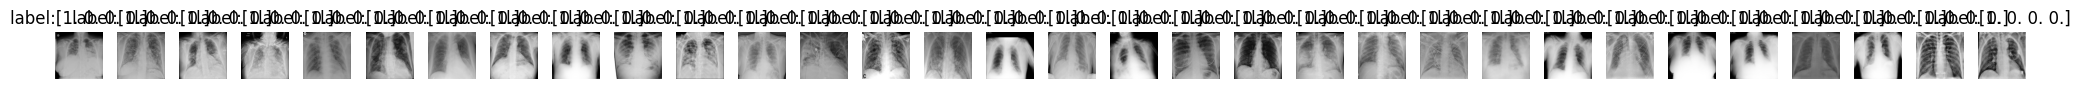

In [17]:
fig,axes=plt.subplots(1,num_images,figsize=(20,5))

    
for i,ax in enumerate(axes):
        
    ax.imshow(test_imgs[i])
    ax.axis('off')
    plt.tight_layout()
    ax.set_title(f"label:{test_labels[i]}")
plt.tight_layout()
plt.show()

In [18]:
predictions=basic_CNN_model.predict(x=test_batches,verbose=0)

In [19]:
np.round(predictions)[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [20]:
test_batches.class_indices

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2, 'Lung_Opacity': 3}

In [21]:
class_names=['COVID','Normal','Viral Pneumonia','Lung_Opacity']

In [22]:
def classification_table(y_true,y_pred,class_names):
    classification_report_dict=classification_report(y_true,y_pred,output_dict=True,target_names=class_names)
    report_df=pd.DataFrame(classification_report_dict)
    return report_df.T
    

In [23]:
y_true=test_batches.classes
y_pred=np.argmax(predictions,axis=1)

In [24]:
classification_table(y_true,y_pred,class_names)

,precision,recall,f1-score,support
COVID,0.721519,0.786207,0.752475,145.000000
Normal,0.846154,0.754902,0.797927,408.000000
Viral Pneumonia,0.777778,0.792453,0.785047,53.000000
Lung_Opacity,0.701107,0.788382,0.742187,241.000000
accuracy,0.772137,0.772137,0.772137,0.772137
macro avg,0.761639,0.780486,0.769409,847.000000
weighted avg,0.779268,0.772137,0.773480,847.000000


In [25]:
confusion_matrix=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=1))

In [26]:
def CM_plot(confusion_matrix, color):
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix,annot=True,cmap=color,xticklabels=class_names,yticklabels=class_names)
    plt.title('Confusion Matrix')
   
    #tick_marks=np.arrange(len(classes))
    plt.xlabel=('True Label')
    plt.ylabel=('Predicted Label')
    plt.show()
    
   

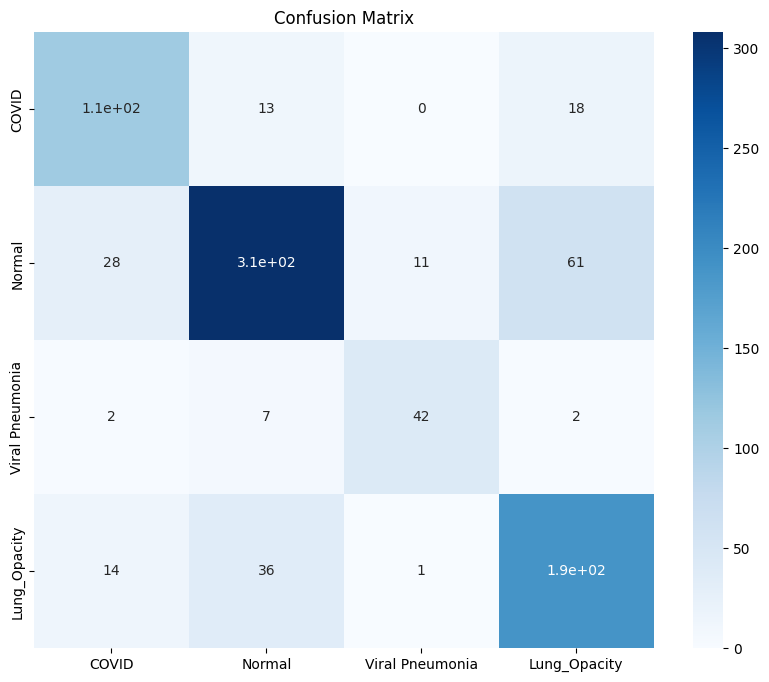

In [27]:
CM_plot(confusion_matrix, "Blues")

In [28]:
confusion_matrix_normalized=confusion_matrix.astype('float')/confusion_matrix.sum(axis=1)[:,np.newaxis]

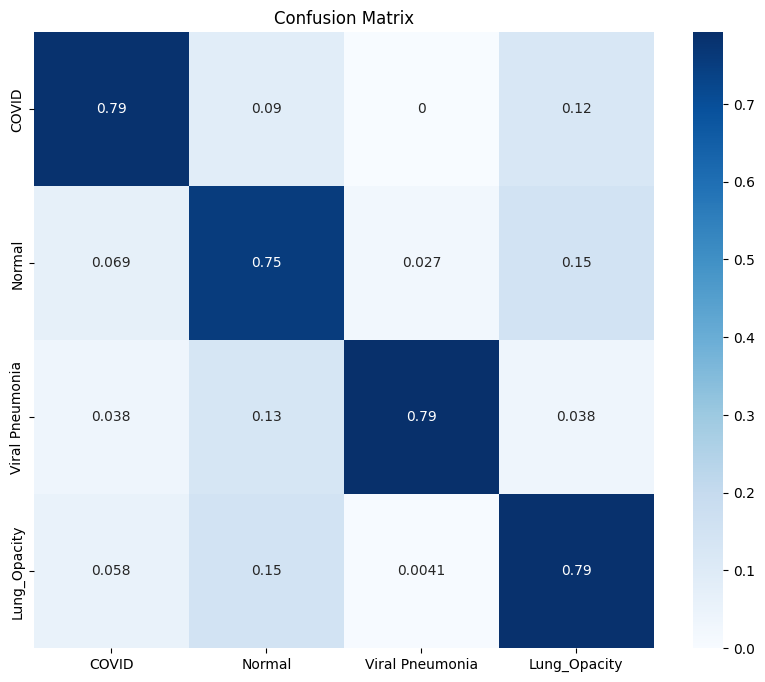

In [29]:
CM_plot(confusion_matrix_normalized, "Blues")

# 3.6 CNN model with Image Augmentation

### 3.6.1 Image Augmentation

In [37]:
#generate batches of data which can be put in sequential model 

#you can add augmentation or rescaling parameters here
#Frist, only apply augmentation to the training dataset

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8048393/
    
Train_Image_generator=ImageDataGenerator(rescale=1./255,rotation_range=15,zoom_range=0.1,horizontal_flip=True, width_shift_range=0.1,brightness_range=[0.9,1.1],fill_mode='nearest')

#not apply to test dataset, only rescale the validation/test dataset
Image_generator_rescale=ImageDataGenerator(rescale=1./255)
#creat batches of data from directory where train,val,test dataset are, target_size are set as 224 since pre-trained model VGG16 is using image with size of 224
train_batches=Train_Image_generator.flow_from_directory(directory=base_train_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
val_batches=Image_generator_rescale.flow_from_directory(directory=base_validation_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
#only set shuffle to be false for test dataset since we need to use test dataset as reference for confusion matrix where
test_batches=Image_generator_rescale.flow_from_directory(directory=base_test_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32,shuffle=False)


Found 4443 images belonging to 4 classes.
Found 637 images belonging to 4 classes.
Found 1271 images belonging to 4 classes.


In [38]:
Aug_CNN_model=Sequential([Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(299,299,3)),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Conv2D(filters=32, kernel_size=(3,3),activation='relu',padding='same'),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Flatten(),
                      Dense(units=4,activation='softmax')])

In [ ]:
Aug_CNN_model.summmary

In [39]:
def fit_model(model,l_r,train,val,ep,vb):
    model.compile(optimizer=Adam(learning_rate=l_r), loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(x=train,validation_data=val,epochs=ep,verbose=vb)
    return model

In [40]:
def pred(model,x_test,vb):
    predictions=model.predict(x=x_test,verbose=vb)
    return predictions
    

In [41]:
def CM_plot(predictions,test_batches,color):
    confusion_matrix=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=1))
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix,annot=True,fmt='d',cmap=color,xticklabels=class_names,yticklabels=class_names)
    plt.title('Confusion Matrix')
   
    #tick_marks=np.arrange(len(classes))
    plt.xlabel=('True Label')
    plt.ylabel=('Predicted Label')
    plt.show()
    
    

In [42]:
Aug_CNN_model_fit=fit_model(Aug_CNN_model,0.0001,train_batches,val_batches,10,1)

Epoch 1/10
139/139 [==============================] - 100s 717ms/step - loss: 0.9962 - accuracy: 0.5690 - val_loss: 0.8476 - val_accuracy: 0.6531
Epoch 2/10
139/139 [==============================] - 77s 556ms/step - loss: 0.9021 - accuracy: 0.6172 - val_loss: 0.8356 - val_accuracy: 0.6515
Epoch 3/10
139/139 [==============================] - 79s 568ms/step - loss: 0.8404 - accuracy: 0.6500 - val_loss: 0.7937 - val_accuracy: 0.6797
Epoch 4/10
139/139 [==============================] - 78s 560ms/step - loss: 0.7983 - accuracy: 0.6730 - val_loss: 0.8115 - val_accuracy: 0.6735
Epoch 5/10
139/139 [==============================] - 78s 558ms/step - loss: 0.7887 - accuracy: 0.6725 - val_loss: 0.7472 - val_accuracy: 0.6970
Epoch 6/10
139/139 [==============================] - 79s 568ms/step - loss: 0.7686 - accuracy: 0.6840 - val_loss: 0.7199 - val_accuracy: 0.7268
Epoch 7/10
139/139 [==============================] - 78s 562ms/step - loss: 0.7440 - accuracy: 0.7004 - val_loss: 0.7240 - val_a

In [14]:
Aug_predictions= Aug_CNN_model_fit.predict(x=test_batches,verbose=0)

NameError: name 'Aug_CNN_model_fit' is not defined

In [ ]:
np.round(Aug_predictions)[:10]

In [ ]:
y_true=test_batches.classes
y_pred=np.argmax(Aug_predictions,axis=1)
classification_table(y_true,y_pred,class_names)

In [ ]:
Aug_confusion_matrix=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(Aug_predictions,axis=1))

In [ ]:
CM_plot(Aug_confusion_matrix, "Blues")

In [ ]:
Aug_confusion_matrix_normalized=Aug_confusion_matrix.astype('float')/Aug_confusion_matrix.sum(axis=1)[:,np.newaxis]

In [ ]:
CM_plot(Aug_confusion_matrix_normalized, "Blues")

### 3.6.2 hyperparameter tuning for augmentation

In [43]:
#1. define grid of parameters
rotation_values=[0,5,10,20]
zoom_values=[0,0.1,0,2]
width_shift_values=[0,0.1]
horizontal_flip=[True,False]

augmentation_configs = []
for width_shift in width_shift_values:
    for rotation in rotation_values:
        for zoom_range in zoom_values:
            config_name = f"ws_{width_shift}_rot_{rotation}_zoom_{zoom_range}"
            augmentation_configs.append({
                'name': config_name,
                'rotation_range': rotation,
                'width_shift_range': width_shift,
                'zoom_range':zoom_range,
                'horizontal_flip':horizontal_flip
       })

In [44]:
def grid_search_augmentation(config,model,train_dir,val_dir,ep):
    train_data_generator=ImageDataGenerator(rescale=1./255,rotation_range=config['rotation_range'],width_shift_range=config['width_shift_range'],
                                           zoom_range=config['zoom_range'],horizontal_flip=config['horizontal_flip'],fill_mode='nearest')
    val_data_generator=ImageDataGenerator(rescale=1./255)
    
    train_batches=train_data_generator.flow_from_directory(directory=train_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=10)
    val_batches=val_data_generator.flow_from_directory(directory=val_dir,target_size=(299,299), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=10)
    model=model
    
    history=model.fit(train_batches,epochs=ep,validation_data=val_batches,vervose=2)
    best_val_accuracy=max(history.history['val_accuracy'])
    return best_val_accuracy


In [ ]:
Aug_CNN_model=Sequential([Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(299,299,3)),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Conv2D(filters=32, kernel_size=(3,3),activation='relu',padding='same'),
                      MaxPool2D(pool_size=(2,2),strides=2),
                      Flatten(),
                      Dense(units=4,activation='softmax')])

In [46]:
results=[]
for config in augmentation_configs:
    accuracy=grid_search_augmentation(config,Aug_CNN_model,train,validation)
    results.append({'configure':config['name'],'Accuracy':accuracy})

NameError: name 'model' is not defined

In [ ]:
results_df = pd.DataFrame(results)
# Display the DataFrame sorted by Accuracy
print(results_df.sort_values(by='Accuracy', ascending=False))

# 3.7 CNN model with hyperparameter tuning

# 3.8 Tranfer Learning

## 3.8.1 Image Preprocessing

In [ ]:
#generate data which can be put in sequential model 

#function for preprocessing the image in the same format of VGG16
#VG16, substract mean RGB value from each pixel
Image_generator=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

#creat batches of data from directory where train,val,test dataset are, target_size are set as 224 since pre-trained model VGG16 is using image with size of 224
train_batches=Image_generator.flow_from_directory(directory=base_train_dir,target_size=(224,224), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
val_batches=Image_generator.flow_from_directory(directory=base_validation_dir,target_size=(224,224), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32)
#only set shuffle to be false for test dataset since we need to use test dataset as reference for confusion matrix where
test_batches=Image_generator.flow_from_directory(directory=base_test_dir,target_size=(224,224), classes=['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity'],batch_size=32,shuffle=False)

In [ ]:
#each batch contains 10 images and corresponding labels
imgs,labels=next(train_batches)

In [ ]:
fig,axes=plt.subplots(1,num_images,figsize=(20,10))

    
for i,ax in enumerate(axes):
        
    ax.imshow(imgs[i])
    ax.axis('off')
    plt.tight_layout()
#    ax.set_title(f"label:{np.argmax(label[i])}")
plt.tight_layout()
plt.show()